In [1]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pathlib import Path

import numpy as np
import pandas as pd
import wrds

from settings import config

DATA_DIR = Path(config("DATA_DIR"))
WRDS_USERNAME = config("WRDS_USERNAME")
START_YEAR = config("START_YEAR")
END_YEAR = config("END_YEAR")

In [2]:
from pull_markit import load_markit_data, load_multiple_data
from pull_rf_data import load_fed_yield_curve, load_fred_data

In [12]:
cds_data = load_multiple_data()

In [13]:
cds_data.dtypes

ticker                object
trade_date    datetime64[ns]
spread               float64
dtype: object

In [14]:
cds_data.sort_values(by="spread")

,ticker,trade_date,spread
139017,USGB,2004-08-24,0.000050
154329,USGB,2004-08-25,0.000050
136367,PADDENT,2021-05-07,0.000051
136366,PADDENT,2021-05-06,0.000051
136365,PADDENT,2021-05-05,0.000051
...,...,...,...
1211,ABK,2019-09-18,341.174771
1209,ABK,2019-09-16,344.889484
237799,TRUVO-SubCo,2010-07-02,345.600000
1210,ABK,2019-09-17,364.612961


In [15]:
fed_data = load_fed_yield_curve()
fred_data = load_fred_data()

In [23]:
def merge_rf_data(fed_data,fred_data,markit):
    rf_data = pd.merge(fred_data,fed_data, on = "Date")
    rf_data = rf_data.merge(markit["trade_date"].drop_duplicates(),left_on="Date",right_on="trade_date", how="inner").set_index("trade_date")
    rf_data.index.name = "Date"
    return rf_data
rf_data = merge_rf_data(fed_data,fred_data,cds_data)

In [26]:
from scipy.interpolate import CubicSpline
def interpolate_row(y):
    x = [0.25,0.5,1,2,3,4,5]
    xvals = np.linspace(1/12,5,60)
    f = CubicSpline(x, y, bc_type="natural")  # Cubic spline interpolation
    return pd.Series(f(xvals), index=xvals)  # Evaluate at xvals


def calc_risk_free_rate(rf_data):
    xvals = np.linspace(1/12,5,60)
    r_t_df = pd.DataFrame(index=rf_data.index, columns=xvals)

    r_t_df.loc[:, :] = rf_data.apply(interpolate_row, axis=1)
    return r_t_df.astype(float)

def calc_lambda(cds_df, L =0.6):
    cds_df["lambda"] = 12 * np.log(1+cds_df["spread"] / (12 * L))
    return cds_df

def calc_risk_free_term(rf_data):

    r_t_df = calc_risk_free_rate(rf_data)

    maturities = np.array(r_t_df.columns, dtype= float)
    for i in range(len(r_t_df)):
        r_t_df.iloc[i] *= maturities

    r_t_df = np.exp(-1 * r_t_df / 12)
    return r_t_df

In [27]:
risk_free_term_df = calc_risk_free_term(rf_data)

In [29]:
markit = cds_data

In [40]:
def calc_RD(cds_df, r_t_df, maturity = 5):
    cds_df["trade_date"] = pd.to_datetime(cds_df["trade_date"])

    # rd_df = cds_df.merge(r_t_df, left_on = "trade_date", right_on = r_t_df.index, how = "left")
    
    rd_df = r_t_df.merge(cds_df, right_on = "trade_date", left_on = r_t_df.index, how = "right")
    
    rd_df = calc_lambda(rd_df)

    rd_df = rd_df.dropna(axis=0)

    rd_df["RD"] = 0
    for j in range(1, 12 * maturity + 1):  
        risk_free_col = rd_df.iloc[:,j-1]
        rd_df["RD"] += np.exp(-j / 12 * rd_df["lambda"]) * risk_free_col
    rd_df["RD"] /= 12

    rd_df = rd_df.sort_values(["ticker", "trade_date"])
    rd_df["RD_prev"] = rd_df.groupby("ticker")["RD"].shift(1)
    rd_df["spread_prev"] = rd_df.groupby("ticker")["spread"].shift(1)

    return rd_df[["ticker","trade_date","spread_prev","spread","RD","RD_prev"]]


In [41]:
rd_df = calc_RD(markit, risk_free_term_df)

In [43]:
def calc_cds_daily_return(rd_df):
    rd_df["daily_return"] = rd_df["spread_prev"] / 250 + (rd_df["spread"] - rd_df["spread_prev"]) * rd_df["RD_prev"]
    rd_df = rd_df.dropna(subset=["daily_return"])
    return rd_df

In [44]:
final_df = calc_cds_daily_return(rd_df)

In [ ]:
rf_data = merge_rf_data(fed_data,fred_data,markit)

risk_free_term_df = calc_risk_free_term(rf_data)

rd_df = calc_RD(markit, risk_free_term_df)

final_df = calc_cds_daily_return(rd_df)

final_df.to_parquet(DATA_DIR / "CDS_return.parquet")

In [55]:
def generate_month_code(date):
    year = date.year
    month = date.month

    if month >= 10:
        return f"{year}{month}"
    else:
        return f"{year}0{month}"

In [47]:
from calc_cds_daily_return import load_cds_return

In [48]:
daily_return_df = load_cds_return()

In [56]:
daily_return_df["yyyymm"] = daily_return_df["trade_date"].apply(generate_month_code)

In [57]:
def calc_cds_monthly_return(daily_rd_df):
    """
    Compute the monthly return by compounding daily returns:
    (1 + Monthly Return) = Π (1 + Daily Return)
    """
    daily_rd_df["yyyymm"] = daily_rd_df["trade_date"].apply(generate_month_code)
    # Aggregate daily returns into monthly compounded returns
    monthly_returns = (
        daily_rd_df.groupby(["ticker", "yyyymm"])["daily_return"]
        .apply(lambda x: (x + 1).prod() - 1)  # Compounding formula
        .reset_index()
    )

    return monthly_returns

In [58]:
monthly_return = calc_cds_monthly_return(daily_return_df)

In [59]:
monthly_return.head()

,ticker,yyyymm,daily_return
0,A,200202,-0.017739
1,A,200203,-0.022884
2,A,200204,-0.004798
3,A,200205,0.004670
4,A,200206,0.013454


In [65]:
daily_return_df

,ticker,trade_date,spread_prev,spread,RD,RD_prev,daily_return,yyyymm
5079594,A,2002-02-05,0.049500,0.046804,4.099960,4.056716,-0.010740,200202
5081224,A,2002-02-06,0.046804,0.046804,4.099776,4.099960,0.000187,200202
5085769,A,2002-02-07,0.046804,0.046804,4.099685,4.099776,0.000187,200202
5000832,A,2002-02-08,0.046804,0.046804,4.100033,4.099685,0.000187,200202
5048745,A,2002-02-11,0.046804,0.046804,4.099979,4.100033,0.000187,200202
...,...,...,...,...,...,...,...,...
3862647,ZION,2008-01-15,0.010707,0.010707,4.753001,4.752348,0.000043,200801
3862648,ZION,2008-01-16,0.010707,0.010707,4.753037,4.753001,0.000043,200801
3862649,ZION,2008-01-17,0.010707,0.010707,4.753883,4.753037,0.000043,200801
3862650,ZION,2008-01-18,0.010707,0.010807,4.752462,4.753883,0.000518,200801


In [67]:
def construct_cds_portfolios(monthly_returns, rd_df):
    """
    Construct 20 portfolios sorted by the first trading day's CDS spread.
    """
    # Get the first trading day of each month
    first_day_spread = rd_df.groupby(["ticker", "yyyymm"]).first()["spread"].reset_index()

    # Rank tickers into 20 portfolios based on spread
    first_day_spread["portfolio"] = first_day_spread.groupby("yyyymm")["spread"].transform(
        lambda x: pd.qcut(x, 20, labels=False) + 1  
    )

    # Merge portfolio assignments into monthly returns
    portfolio_returns = monthly_returns.merge(first_day_spread[["ticker", "yyyymm", "portfolio"]], on=["ticker", "yyyymm"])

    # Compute value-weighted portfolio returns
    final_portfolio_returns = portfolio_returns.groupby(["yyyymm", "portfolio"])["daily_return"].mean().reset_index()

    return final_portfolio_returns

In [68]:
portfolio = construct_cds_portfolios(monthly_return,daily_return_df)

In [ ]:
portfolio = 

,yyyymm,portfolio,daily_return
0,200101,1,0.002038
1,200101,2,-0.002141
2,200101,3,0.002193
3,200101,4,-0.003723
4,200101,5,-0.001734
...,...,...,...
5815,202503,16,0.002496
5816,202503,17,0.004741
5817,202503,18,0.002968
5818,202503,19,0.004521


In [2]:
from create_portfolio import load_portfolio
portfolio = load_portfolio()

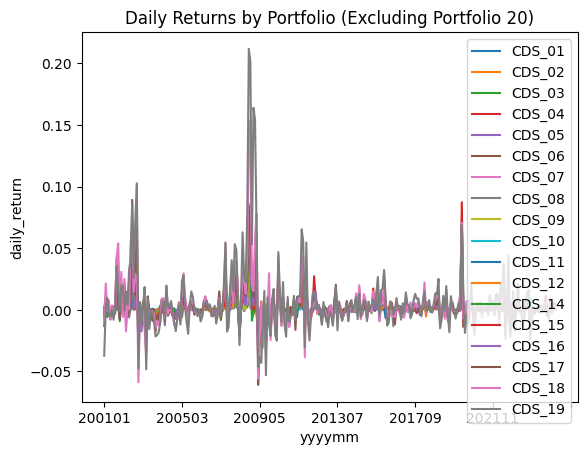

In [8]:
import matplotlib.pyplot as plt

# Exclude portfolio 20 by filtering the DataFrame
filtered_df = portfolio[(portfolio['portfolio'] != 20) & (portfolio['portfolio'] != 13)]

# Pivot using the filtered DataFrame
df_pivot = filtered_df.pivot(index='yyyymm', columns='portfolio', values='daily_return')

# Rename the columns to "CDS_XX"
df_pivot.columns = [f"CDS_{str(col).zfill(2)}" for col in df_pivot.columns]

# Plot all portfolios except 20
df_pivot.plot()
plt.title("Daily Returns by Portfolio (Excluding Portfolio 20)")
plt.xlabel("yyyymm")
plt.ylabel("daily_return")
plt.show()


In [ ]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd
def process_real_cds_return():
    '''
    Reading the original returns which were to be replicated
    '''
    actual_return = pd.read_csv('../data_manual/He_Kelly_Manela_Factors_And_Test_Assets_monthly.csv')
    actual_return = actual_return[['yyyymm','CDS_01','CDS_02','CDS_03','CDS_04','CDS_05','CDS_06','CDS_07','CDS_08','CDS_09','CDS_10','CDS_11','CDS_12','CDS_13','CDS_14','CDS_15','CDS_16','CDS_17','CDS_18','CDS_19','CDS_20']]
    actual_return = actual_return.dropna(axis=0)
    actual_return['yyyymm'] = pd.to_datetime(actual_return['yyyymm'], format='%Y%m')
    actual_return['yyyymm']= actual_return['yyyymm'] + MonthEnd(1)
    actual_return = actual_return.set_index('yyyymm')
    return actual_return

In [27]:
actual_return = pd.read_csv('../data_manual/He_Kelly_Manela_Factors_And_Test_Assets_monthly.csv')
actual_return = actual_return[['yyyymm','CDS_01','CDS_02','CDS_03','CDS_04','CDS_05','CDS_06','CDS_07','CDS_08','CDS_09','CDS_10','CDS_11','CDS_12','CDS_13','CDS_14','CDS_15','CDS_16','CDS_17','CDS_18','CDS_19','CDS_20']]
actual_return = actual_return.dropna(axis=0)

In [28]:
actual_return

,yyyymm,CDS_01,CDS_02,CDS_03,CDS_04,CDS_05,CDS_06,CDS_07,CDS_08,CDS_09,CDS_10,CDS_11,CDS_12,CDS_13,CDS_14,CDS_15,CDS_16,CDS_17,CDS_18,CDS_19,CDS_20
373,200102.0,0.0039,0.0040,0.0033,0.0024,0.0093,0.0030,0.0020,0.0048,0.0044,0.0039,0.0078,-0.0036,0.0042,0.0057,0.0027,-0.0153,-0.0032,0.0070,0.0005,0.0193
374,200103.0,0.0012,0.0041,0.0061,0.0045,0.0073,0.0059,0.0079,0.0071,0.0087,-0.0112,0.0060,0.0042,0.0032,0.0068,-0.0012,0.0093,0.0083,-0.0012,0.0072,0.0219
375,200104.0,0.0033,0.0044,0.0044,0.0060,0.0054,0.0037,0.0044,0.0044,0.0068,0.0021,0.0098,0.0106,0.0084,0.0098,0.0083,0.0124,0.0061,0.0109,0.0041,-0.0018
376,200105.0,0.0038,0.0043,0.0045,0.0039,0.0044,0.0039,0.0040,0.0075,0.0045,0.0034,0.0076,0.0078,0.0049,0.0117,0.0108,0.0061,0.0150,0.0152,0.0184,0.0140
377,200106.0,0.0030,0.0027,0.0044,0.0037,0.0079,0.0042,0.0053,0.0035,0.0040,0.0011,0.0031,0.0029,0.0038,0.0045,0.0034,0.0044,0.0020,0.0073,0.0065,-0.0007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,201208.0,0.0005,0.0009,0.0013,0.0011,0.0022,0.0022,0.0024,0.0017,0.0015,0.0026,0.0031,0.0015,0.0035,0.0032,0.0043,0.0062,0.0084,0.0060,0.0051,0.0152
512,201209.0,0.0012,0.0010,0.0020,0.0022,0.0030,0.0023,0.0030,0.0033,0.0039,0.0045,0.0049,0.0059,0.0057,0.0087,0.0070,0.0083,0.0092,0.0120,0.0119,0.0174
513,201210.0,0.0010,0.0009,0.0009,0.0016,0.0018,0.0019,0.0014,0.0010,0.0019,0.0010,0.0008,0.0028,0.0043,0.0042,0.0013,0.0045,0.0033,0.0028,-0.0010,0.0045
514,201211.0,-0.0006,-0.0007,-0.0009,-0.0007,-0.0010,-0.0010,-0.0009,-0.0016,-0.0016,0.0007,-0.0037,-0.0005,-0.0012,0.0005,0.0015,-0.0002,0.0026,0.0027,0.0107,0.0015


In [14]:
actual_df = process_real_cds_return()

<Axes: xlabel='yyyymm'>

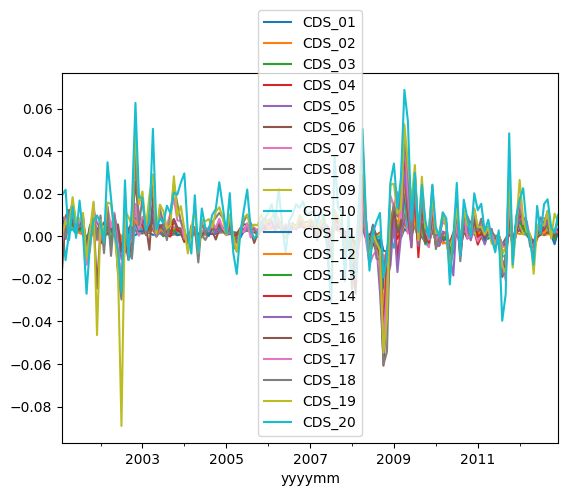

In [15]:
actual_df.plot()

In [22]:
def generate_month_code(date):
    year = date.year
    month = date.month

    if month >= 10:
        return f"{year}{month}"
    else:
        return f"{year}0{month}"

In [24]:
actual_df["yyyymm"] = actual_df.index.map(generate_month_code)

In [26]:
actual_df

,CDS_01,CDS_02,CDS_03,CDS_04,CDS_05,CDS_06,CDS_07,CDS_08,CDS_09,CDS_10,CDS_11,CDS_12,CDS_13,CDS_14,CDS_15,CDS_16,CDS_17,CDS_18,CDS_19,CDS_20,yyyymm
yyyymm,,,,,,,,,,,,,,,,,,,,,
2001-02-28,0.0039,0.0040,0.0033,0.0024,0.0093,0.0030,0.0020,0.0048,0.0044,0.0039,0.0078,-0.0036,0.0042,0.0057,0.0027,-0.0153,-0.0032,0.0070,0.0005,0.0193,200102
2001-03-31,0.0012,0.0041,0.0061,0.0045,0.0073,0.0059,0.0079,0.0071,0.0087,-0.0112,0.0060,0.0042,0.0032,0.0068,-0.0012,0.0093,0.0083,-0.0012,0.0072,0.0219,200103
2001-04-30,0.0033,0.0044,0.0044,0.0060,0.0054,0.0037,0.0044,0.0044,0.0068,0.0021,0.0098,0.0106,0.0084,0.0098,0.0083,0.0124,0.0061,0.0109,0.0041,-0.0018,200104
2001-05-31,0.0038,0.0043,0.0045,0.0039,0.0044,0.0039,0.0040,0.0075,0.0045,0.0034,0.0076,0.0078,0.0049,0.0117,0.0108,0.0061,0.0150,0.0152,0.0184,0.0140,200105
2001-06-30,0.0030,0.0027,0.0044,0.0037,0.0079,0.0042,0.0053,0.0035,0.0040,0.0011,0.0031,0.0029,0.0038,0.0045,0.0034,0.0044,0.0020,0.0073,0.0065,-0.0007,200106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-08-31,0.0005,0.0009,0.0013,0.0011,0.0022,0.0022,0.0024,0.0017,0.0015,0.0026,0.0031,0.0015,0.0035,0.0032,0.0043,0.0062,0.0084,0.0060,0.0051,0.0152,201208
2012-09-30,0.0012,0.0010,0.0020,0.0022,0.0030,0.0023,0.0030,0.0033,0.0039,0.0045,0.0049,0.0059,0.0057,0.0087,0.0070,0.0083,0.0092,0.0120,0.0119,0.0174,201209
2012-10-31,0.0010,0.0009,0.0009,0.0016,0.0018,0.0019,0.0014,0.0010,0.0019,0.0010,0.0008,0.0028,0.0043,0.0042,0.0013,0.0045,0.0033,0.0028,-0.0010,0.0045,201210


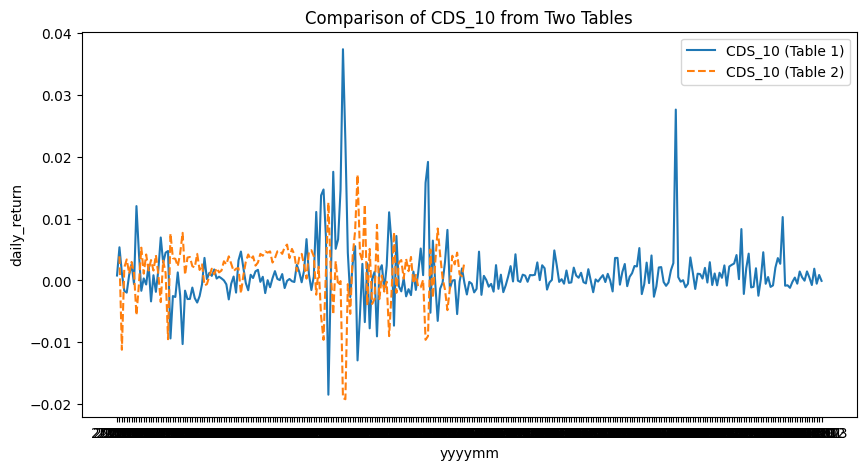

In [25]:
plt.figure(figsize=(10, 5))

plt.plot(df_pivot.index, df_pivot["CDS_10"], label="CDS_10 (Table 1)", linestyle="-")
plt.plot(actual_df["yyyymm"], actual_df["CDS_10"], label="CDS_10 (Table 2)", linestyle="--")

plt.title("Comparison of CDS_10 from Two Tables")
plt.xlabel("yyyymm")
plt.ylabel("daily_return")
plt.legend()
plt.show()